This notebook aims to show how we could approach this competition in a realistic setting. This means in a setting where we genuinely do not have the test set and we have to deliver a model that performs reasonably well. Moreover, we want to be able to explain where our model shines and where it is not as trustworthy.

The key concepts for a realistic end-to-end project that we will explore are:

* efficient validation strategy, because we will rely solely on this to chose and perfect our final model
* use of pipelines, because we want to simply apply our final result to unseen data (the test set)
* feature engineering and feature selection, because we want to do both quickly and efficiently
* utility scripts are your friends, because nobody likes having so much code in the notebook.

The steps we will follow are:

**Note: this notebook is still a work in progress, in bold the sections that are already there**

* **data cleaning**
* **data exploration**
* **first models**
* **feature engineering**
* hyperparameter tuning
* stacking



In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

import df_pipeline as dfp  # all the custom pipeline parts
import explore_data as exp  # all function to quickly explore the data

import warnings

pd.set_option('max_columns', 200)

# A first look at the data and a validation strategy

The goal here is only to get an idea about the structure, the data types, the missing values. We should try to not take any decisions just yet because we did not set up any validation strategy yet. 

Note also that we do not load the test set, for the purposes of this notebook the test set is needed only for the final submission. Imagine the test set as the one that your client sends you a month after you delivered your model.

In [2]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Very well, we have a good combination of numerical, ordinal, and categorical features (which is also why this is a good competition to start with). We also have quite a few missing values (most of which are explained in the data description).

In [3]:
col_mis = exp.list_missing(df_train)

Column LotFrontage: 17.74% missing
Column Alley: 93.77% missing
Column MasVnrType: 0.55% missing
Column MasVnrArea: 0.55% missing
Column BsmtQual: 2.53% missing
Column BsmtCond: 2.53% missing
Column BsmtExposure: 2.6% missing
Column BsmtFinType1: 2.53% missing
Column BsmtFinType2: 2.6% missing
Column Electrical: 0.07% missing
Column FireplaceQu: 47.26% missing
Column GarageType: 5.55% missing
Column GarageYrBlt: 5.55% missing
Column GarageFinish: 5.55% missing
Column GarageQual: 5.55% missing
Column GarageCond: 5.55% missing
Column PoolQC: 99.52% missing
Column Fence: 80.75% missing
Column MiscFeature: 96.3% missing


And, by looking at the distribution of the data, we have some odd values

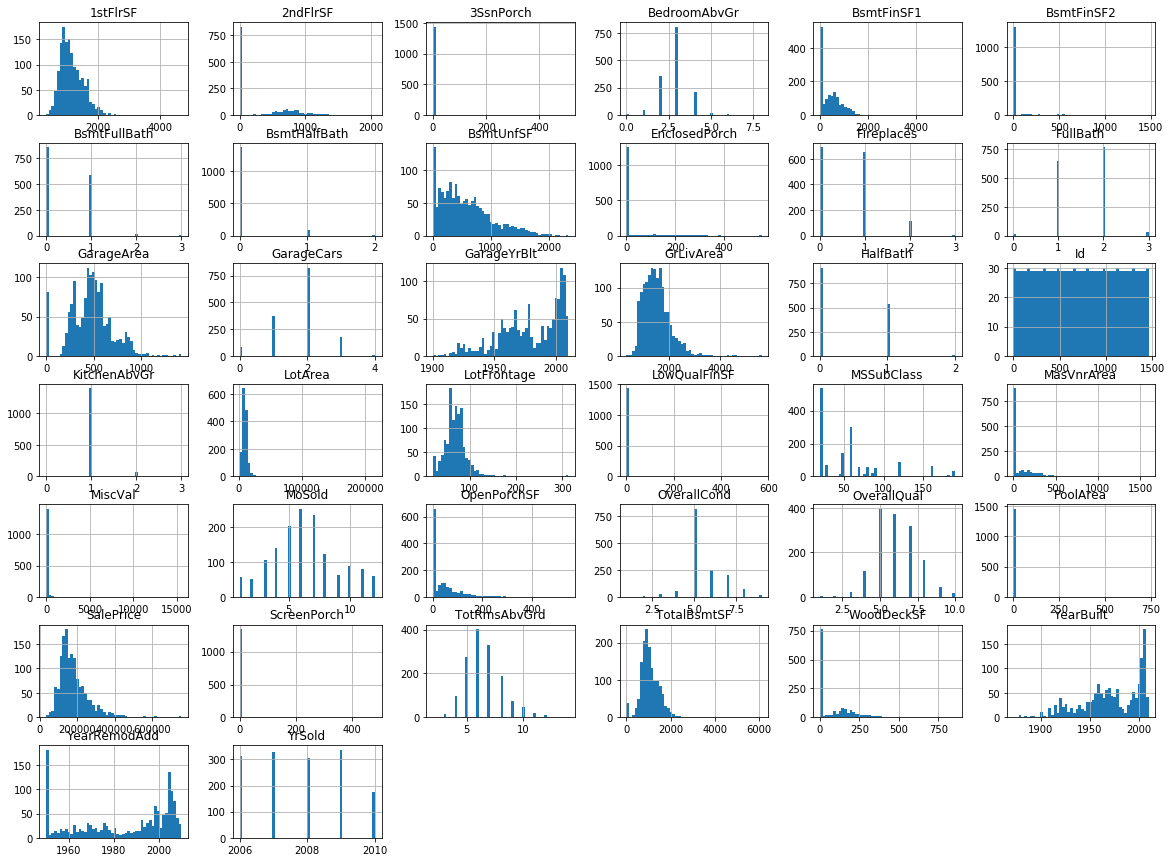

In [4]:
df_train.hist(bins=50, figsize=(20,15))
plt.show()

All the information I want to get from these plots are about odd distributions, not only I see there is a skew in some continuous variables, but also that some features have mostly one value.

One way to remove the skeweness is to simply take the logarithm of the variable. This is what we are going to do now with the target variable

In [5]:
df_train['target'] = np.log1p(df_train.SalePrice)
del df_train['SalePrice']

We will implement a cleaning procedure that follows the documentation shortly but, before even creating the evaluation environment, we want to remove 2 outliers that the documentation recommends to remove. See this step as following the instructions that came with the data.

In [6]:
df_train = df_train[df_train.GrLivArea < 4500].reset_index(drop=True)

Now, since we want to evaluate our model in order to be able to say how good or bad it can be in certain situations, we need to create our test set (not the test set provided by kaggle, that one will arrive in a month after we are done). Every insight and every decision will come from something we will do on the train set, leaving the evaluation of our choices as pure as possible.

If we were doing the data exploration phase before this step, we would have used information coming from both sets to take decisions, a luxury that in a realistic situation we won't have.

How to split the data? Giving the size of the training set, it makes sense to use a 80-20 split. A random split will do the job just fine but we can also use some knowledge of the problem. Since all that matters for a house is *location, location, location* , we can make the split in order to correctly represent the distribution of the houses across the various Neighborhoods (i.e. we can *stratify* the split).

In [7]:
def make_test(train, test_size, random_state, strat_feat=None):
    if strat_feat:
        
        split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)

        for train_index, test_index in split.split(train, train[strat_feat]):
            train_set = train.loc[train_index]
            test_set = train.loc[test_index]
            
    return train_set, test_set

In [8]:
train_set, test_set = make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

And we see that the proportion of houses per Neighborhood is approximatively preserved

In [9]:
train_set.Neighborhood.value_counts(normalize=True)

NAmes      0.154374
CollgCr    0.102916
OldTown    0.077187
Edwards    0.066895
Somerst    0.059177
Gilbert    0.054031
NridgHt    0.053173
Sawyer     0.050600
NWAmes     0.049743
SawyerW    0.040309
BrkSide    0.039451
Crawfor    0.035163
Mitchel    0.033448
NoRidge    0.028302
Timber     0.025729
IDOTRR     0.025729
ClearCr    0.018868
SWISU      0.017153
StoneBr    0.017153
MeadowV    0.012007
Blmngtn    0.012007
BrDale     0.011149
Veenker    0.007719
NPkVill    0.006003
Blueste    0.001715
Name: Neighborhood, dtype: float64

In [10]:
df_train.Neighborhood.value_counts(normalize=True)

NAmes      0.154321
CollgCr    0.102881
OldTown    0.077503
Edwards    0.067215
Somerst    0.058985
Gilbert    0.054184
NridgHt    0.052812
Sawyer     0.050754
NWAmes     0.050069
SawyerW    0.040466
BrkSide    0.039781
Crawfor    0.034979
Mitchel    0.033608
NoRidge    0.028121
Timber     0.026063
IDOTRR     0.025377
ClearCr    0.019204
SWISU      0.017147
StoneBr    0.017147
MeadowV    0.011660
Blmngtn    0.011660
BrDale     0.010974
Veenker    0.007545
NPkVill    0.006173
Blueste    0.001372
Name: Neighborhood, dtype: float64

Before getting insights from the data, let's take the final step of the instructions that came with the data (i.e. the data description) and have a general cleaning

In [11]:
class general_cleaner(BaseEstimator, TransformerMixin):
    '''
    This class applies what we know from the documetation.
    It cleans some known missing values
    If flags the missing values

    This process is supposed to happen as first step of any pipeline
    '''
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        #LotFrontage
        X.loc[X.LotFrontage.isnull(), 'LotFrontage'] = 0
        #Alley
        X.loc[X.Alley.isnull(), 'Alley'] = "NoAlley"
        #MSSubClass
        X['MSSubClass'] = X['MSSubClass'].astype(str)
        #MissingBasement
        fil = ((X.BsmtQual.isnull()) & (X.BsmtCond.isnull()) & (X.BsmtExposure.isnull()) &
              (X.BsmtFinType1.isnull()) & (X.BsmtFinType2.isnull()))
        fil1 = ((X.BsmtQual.notnull()) | (X.BsmtCond.notnull()) | (X.BsmtExposure.notnull()) |
              (X.BsmtFinType1.notnull()) | (X.BsmtFinType2.notnull()))
        X.loc[fil1, 'MisBsm'] = 0
        X.loc[fil, 'MisBsm'] = 1 # made explicit for safety
        #BsmtQual
        X.loc[fil, 'BsmtQual'] = "NoBsmt" #missing basement
        #BsmtCond
        X.loc[fil, 'BsmtCond'] = "NoBsmt" #missing basement
        #BsmtExposure
        X.loc[fil, 'BsmtExposure'] = "NoBsmt" #missing basement
        #BsmtFinType1
        X.loc[fil, 'BsmtFinType1'] = "NoBsmt" #missing basement
        #BsmtFinType2
        X.loc[fil, 'BsmtFinType2'] = "NoBsmt" #missing basement
        #BsmtFinSF1
        X.loc[fil, 'BsmtFinSF1'] = 0 # No bsmt
        #BsmtFinSF2
        X.loc[fil, 'BsmtFinSF2'] = 0 # No bsmt
        #BsmtUnfSF
        X.loc[fil, 'BsmtUnfSF'] = 0 # No bsmt
        #TotalBsmtSF
        X.loc[fil, 'TotalBsmtSF'] = 0 # No bsmt
        #BsmtFullBath
        X.loc[fil, 'BsmtFullBath'] = 0 # No bsmt
        #BsmtHalfBath
        X.loc[fil, 'BsmtHalfBath'] = 0 # No bsmt
        #FireplaceQu
        X.loc[(X.Fireplaces == 0) & (X.FireplaceQu.isnull()), 'FireplaceQu'] = "NoFire" #missing
        #MisGarage
        fil = ((X.GarageYrBlt.isnull()) & (X.GarageType.isnull()) & (X.GarageFinish.isnull()) &
              (X.GarageQual.isnull()) & (X.GarageCond.isnull()))
        fil1 = ((X.GarageYrBlt.notnull()) | (X.GarageType.notnull()) | (X.GarageFinish.notnull()) |
              (X.GarageQual.notnull()) | (X.GarageCond.notnull()))
        X.loc[fil1, 'MisGarage'] = 0
        X.loc[fil, 'MisGarage'] = 1
        #GarageYrBlt
        X.loc[X.GarageYrBlt > 2200, 'GarageYrBlt'] = 2007 #correct mistake
        X.loc[fil, 'GarageYrBlt'] = X['YearBuilt']  # if no garage, use the age of the building
        #GarageType
        X.loc[fil, 'GarageType'] = "NoGrg" #missing garage
        #GarageFinish
        X.loc[fil, 'GarageFinish'] = "NoGrg" #missing
        #GarageQual
        X.loc[fil, 'GarageQual'] = "NoGrg" #missing
        #GarageCond
        X.loc[fil, 'GarageCond'] = "NoGrg" #missing
        #Fence
        X.loc[X.Fence.isnull(), 'Fence'] = "NoFence" #missing fence
        #Pool
        fil = ((X.PoolArea == 0) & (X.PoolQC.isnull()))
        X.loc[fil, 'PoolQC'] = 'NoPool' 
        
        del X['Id']
        del X['MiscFeature']  # we already know it doesn't matter
        
        return X

Why a class? Because we want to be able to reproduce every step on unseen data and a class makes easier to have a very clear set of steps to follow. More explanation on this and on the use of Pipelines (that will come later) can be found in this other notebook https://www.kaggle.com/lucabasa/understand-and-use-a-pipeline

To use this class and clean our data, we can simply do

In [12]:
train_cleaned = train_set.copy()  # I want to work on train_set again later from scratch

train_cleaned = general_cleaner().fit_transform(train_cleaned)

mis_cols = exp.list_missing(train_cleaned)

Column MasVnrType: 0.69% missing
Column MasVnrArea: 0.69% missing
Column BsmtFinType2: 0.09% missing
Column Electrical: 0.09% missing


We see that most of the missing values were actually very well explained by the documentation, we will deal with the remaining ones later on.

Please note that we don't know what is going to be missing in the future, thus, even if there were no missing values remaining in our data, we should implement procedures to clean the data anyway (or, in alternative, throw appropriate errors so that the team maintaing the model will know quickly what to do).

# Get insights from the data

This phase is tricky because it is easy to go too deep into the rabbit hole. We want to have a comprehensive understanding of the data but at the same time we don't want to spend too much time on it. While in this dataset the number of features is fairly limited, in other cases a slow approach can cost us weeks of work and, at this stage, we don't know if this work is worth weeks of our time.

We will thus focus on the following:

* Correlation with the target
* Univariate and bivariate analysis of the interesting features
* Interesting segmentations with categorical features

Once again, please note how we don't use the full training set but only what we have created in the previous section.

## Numerical features

To first identify what can be interesting, we can look the correlations with the target. This is not by any means enough or necessary to make a feature interesting but, in absence of other knowledge, it is a good first step.

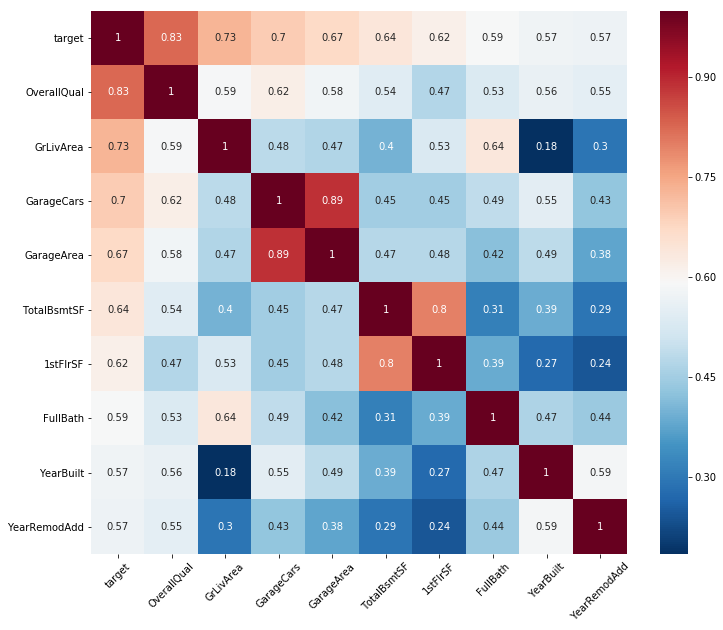

In [13]:
high_corr = exp.plot_correlations(train_cleaned, 'target', limit=10, annot=True)

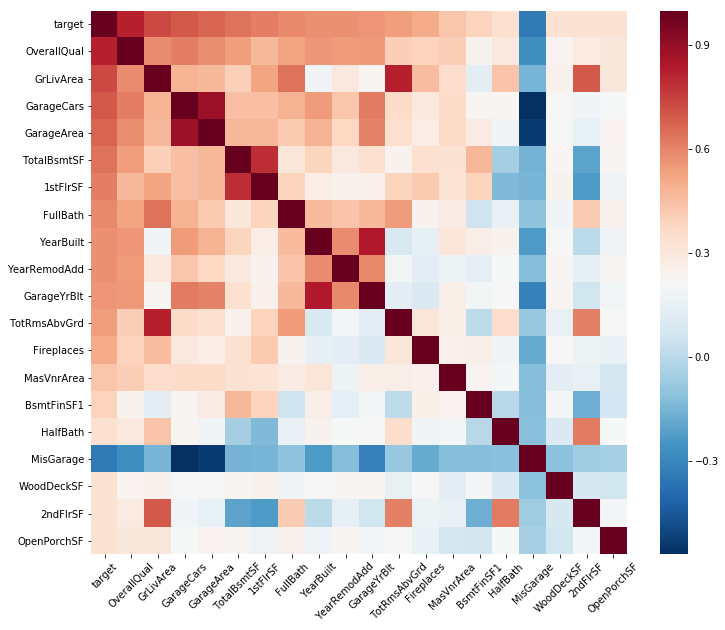

In [14]:
high_corr = exp.plot_correlations(train_cleaned, 'target', limit=20)

Nothing particularly shocking here:

* Overall quality and price are very correlated
* GarageCars and GarageArea are very correlated
* Other fairly expected things

Let's have a look at some distributions, starting with the target variable.

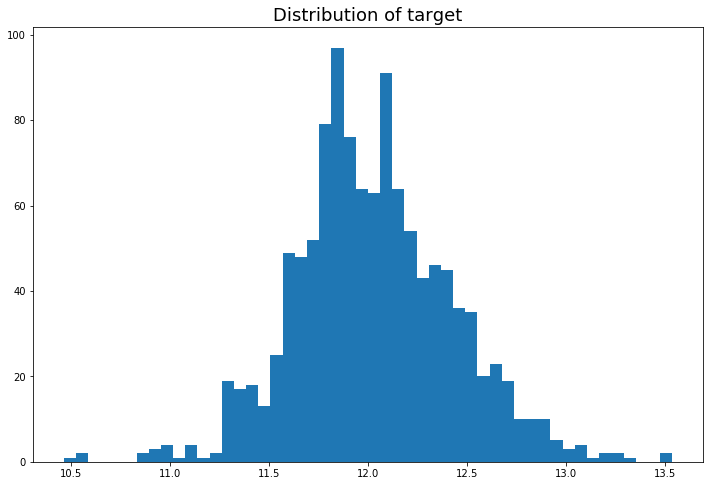

In [15]:
exp.plot_distribution(train_cleaned, 'target')

Yes, we removed the skewness with that logarithm transformation in the previous section.

Let's continue by looking at the numerical features most correlated with the target.

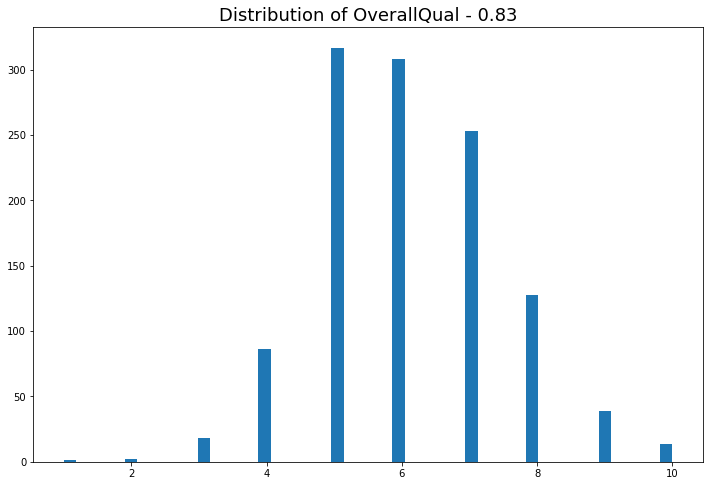

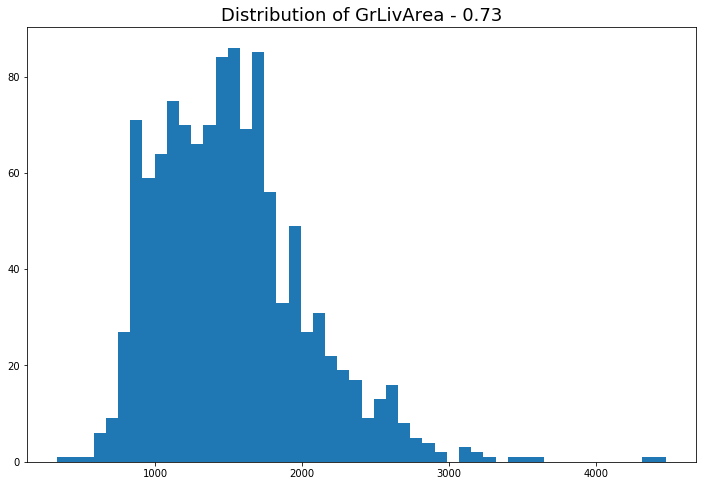

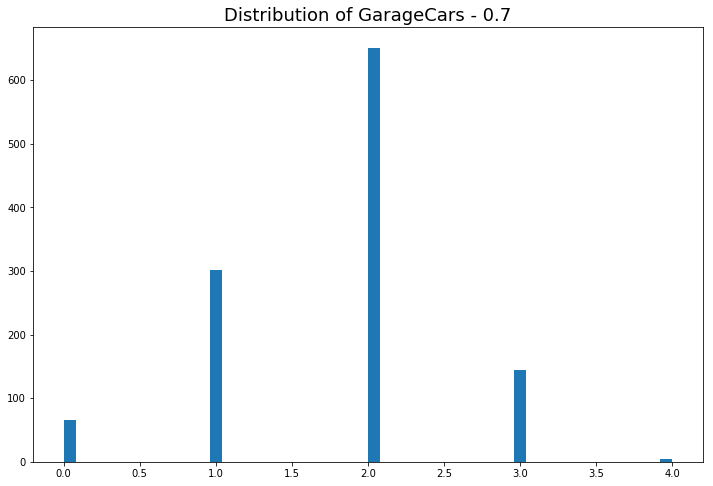

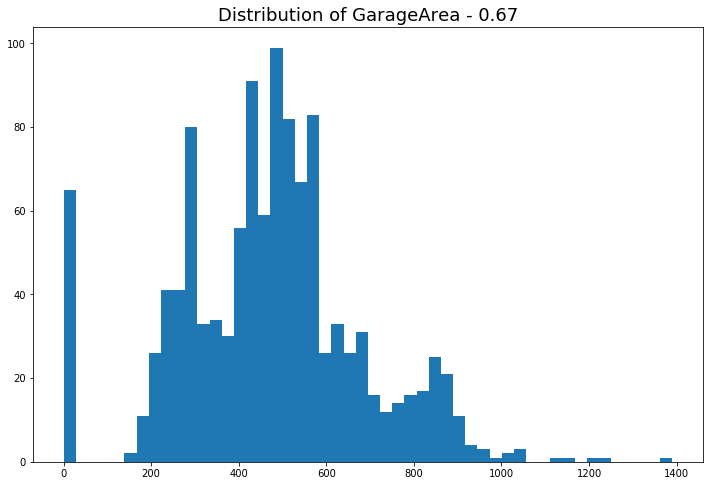

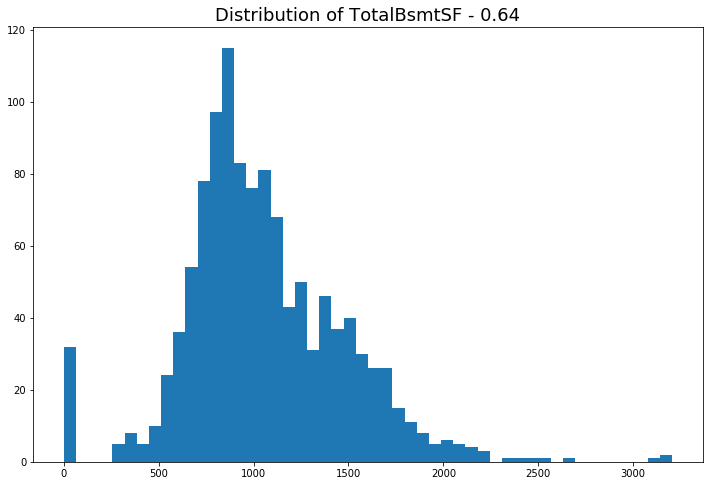

In [16]:
for col in high_corr[1:6].index:
    exp.plot_distribution(train_cleaned, col, correlation=high_corr)

We see, for example, that the negative skew is also present in GrLivArea, a feature that we all expect playing a big role in determining the final price. 

Let's try to get more insights with a bivariate analysis

              OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
OverallQual      1.000000   0.587055    0.618582    0.577956     0.541684   
GrLivArea        0.587055   1.000000    0.482516    0.471170     0.399067   
GarageCars       0.618582   0.482516    1.000000    0.889179     0.449308   
GarageArea       0.577956   0.471170    0.889179    1.000000     0.474743   
TotalBsmtSF      0.541684   0.399067    0.449308    0.474743     1.000000   
1stFlrSF         0.471802   0.530118    0.450187    0.476417     0.796268   
FullBath         0.531866   0.638428    0.488032    0.423072     0.311910   
YearBuilt        0.562561   0.184469    0.548583    0.486097     0.389798   
YearRemodAdd     0.551677   0.295764    0.431481    0.378194     0.294774   
GarageYrBlt      0.555664   0.230821    0.620629    0.607188     0.339224   
TotRmsAbvGrd     0.410755   0.824105    0.367417    0.339575     0.250345   
target           0.826131   0.730448    0.696102    0.673793     0.641253   

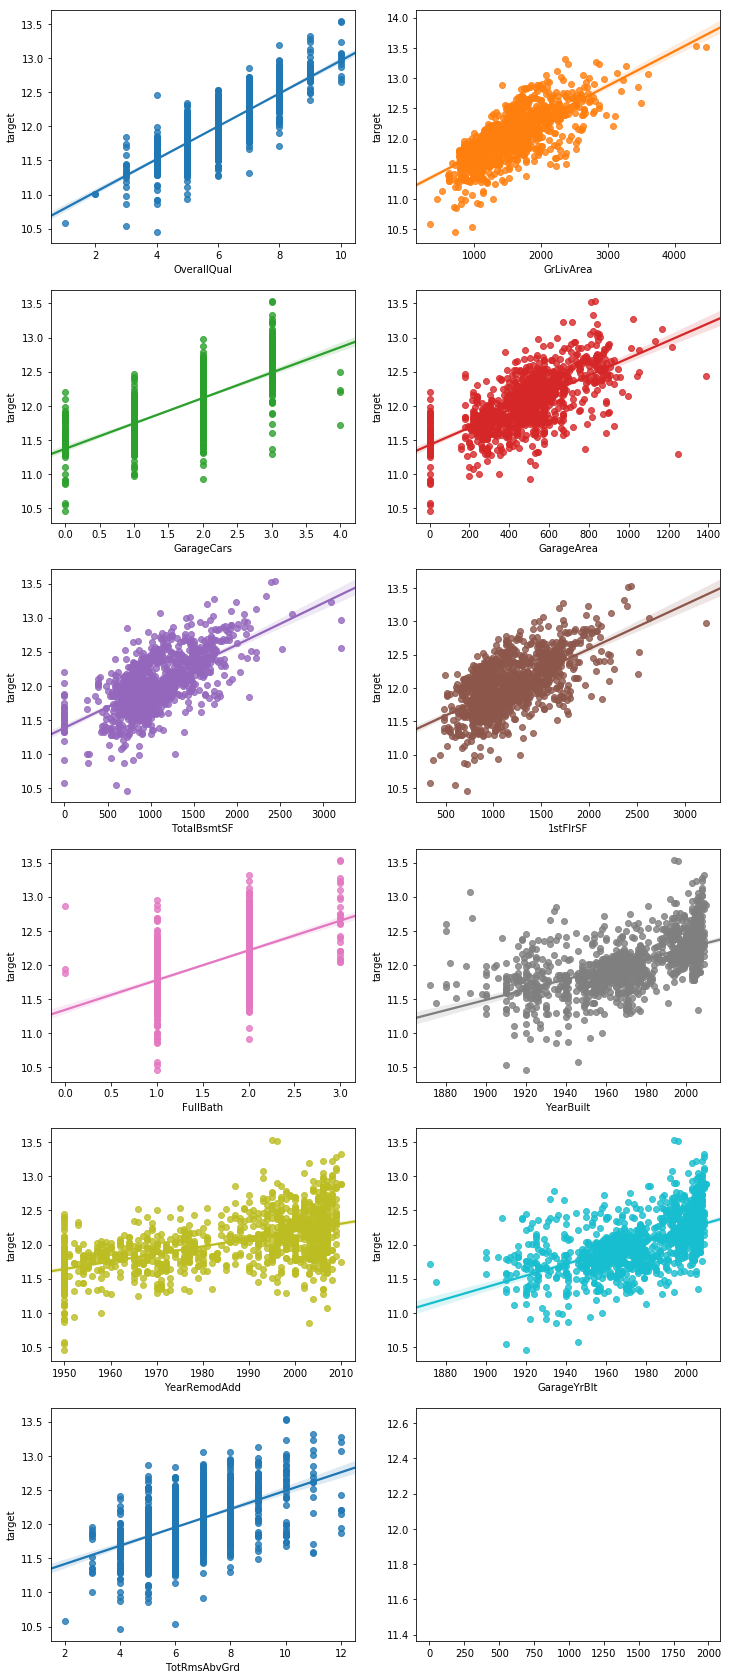

In [17]:
exp.corr_target(train_cleaned, 'target', list(high_corr[1:12].index))

The discrete values of GarageCars and OverallQual invite in using some estimator to see if the patter is clear as it looks.

             OverallQual  GarageCars    target
OverallQual     1.000000    0.618582  0.826131
GarageCars      0.618582    1.000000  0.696102
target          0.826131    0.696102  1.000000


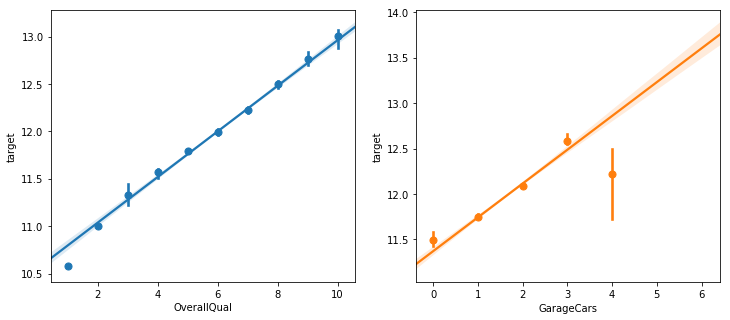

In [18]:
exp.corr_target(train_cleaned, 'target',
                [col for col in high_corr.index if 'Qual' in col or 'Car' in col],
                x_estimator=np.median)

Yes, it is very clear indeed. Let's move on to the categorical features.

## Categorical features

In this dataset we don't have many features and, thanks to the function in the `explore_data` utility script, we can quickly shuffle through all of them to find the interesting one. If this was not possible, one approach would be to find the features whose cateogories exhibit a significantly different distribution of the target variable. In other words, for example, if the distribution of prices for houses withouth a Fence is significantly different than the ones with a Fence, the next function will catch it and tell us.

In [19]:
exp.find_cats(train_cleaned, 'target', thrs=0.3, critical=0.05)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:4862: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(data2, data_all, side='right') / n2
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:4867: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


['LotShape',
 'HouseStyle',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'KitchenQual']

We can start from these to see if we get some insight

,count,mean,max,min,median,std
BsmtQual,,,,,,
Ex,92,12.661743,13.534474,11.724005,12.683831,0.343460
Fa,22,11.726709,12.239996,11.198228,11.734057,0.262231
Gd,496,12.184570,13.195616,11.289794,12.178193,0.284848
NoBsmt,32,11.532958,12.198549,10.579005,11.552167,0.301022
TA,524,11.807075,13.071072,10.460271,11.813037,0.300840


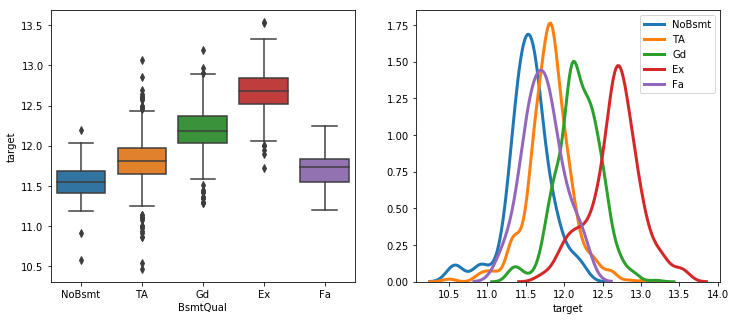

In [20]:
exp.segm_target(train_cleaned, 'BsmtQual', 'target')

It seems there is a very clear relation between the quality of the basement and the sale price. Moreover, it invites in recoding `BsmtQual` into an ordinal feature.

The same holds for `KitchenQual`

,count,mean,max,min,median,std
KitchenQual,,,,,,
Ex,81,12.675378,13.534474,11.429555,12.691584,0.376239
Fa,31,11.465739,12.069686,10.579005,11.594515,0.371069
Gd,463,12.224121,12.991756,11.277216,12.225880,0.282112
TA,591,11.811277,12.791359,10.460271,11.820418,0.277610


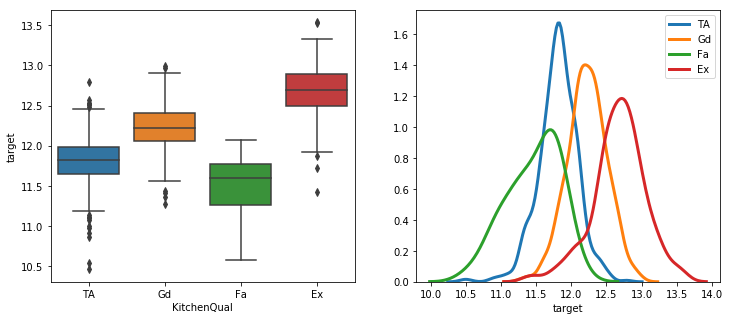

In [21]:
exp.segm_target(train_cleaned, 'KitchenQual', 'target')

Or of `ExterQual`

,count,mean,max,min,median,std
ExterQual,,,,,,
Ex,41,12.804920,13.534474,12.081082,12.823631,0.319093
Fa,11,11.220981,11.711785,10.579005,11.314487,0.329191
Gd,391,12.310935,13.521141,10.859018,12.314932,0.288026
TA,723,11.840067,12.850557,10.460271,11.845110,0.290072


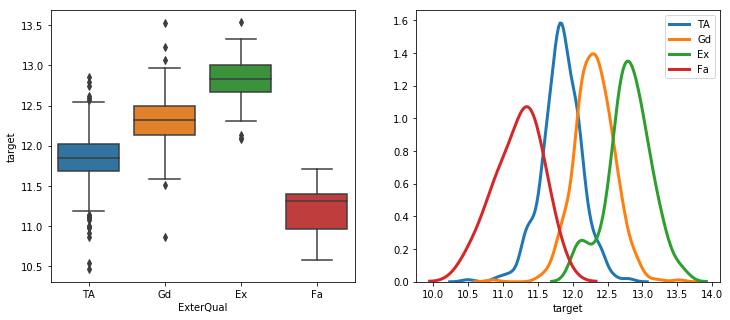

In [22]:
exp.segm_target(train_cleaned, 'ExterQual', 'target')

,count,mean,max,min,median,std
LotShape,,,,,,
IR1,370,12.185910,13.534474,10.859018,12.157409,0.373096
IR2,35,12.333127,13.195616,11.884496,12.310437,0.344046
IR3,7,12.136881,12.523530,11.198228,12.165985,0.462872
Reg,754,11.932324,13.275829,10.460271,11.884496,0.383705


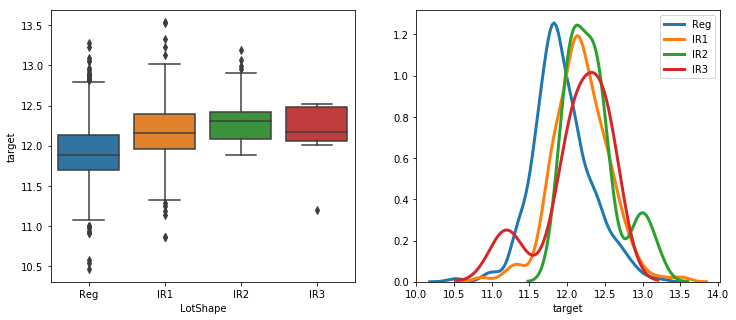

In [23]:
exp.segm_target(train_cleaned, 'LotShape', 'target')

Here it looks it makes a difference only in having a regular vs irregular lot shape.

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,count,mean,max,min,median,std
MasVnrType,,,,,,
BrkCmn,11,11.885626,12.531776,11.607335,11.842236,0.263243
BrkFace,352,12.173350,13.534474,11.320566,12.125406,0.347471
None,697,11.893713,13.521141,10.460271,11.867104,0.364996
Stone,98,12.429558,13.323929,11.686887,12.425865,0.377575


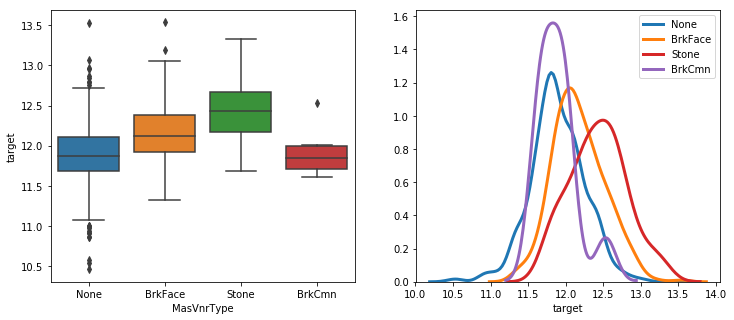

In [24]:
exp.segm_target(train_cleaned, 'MasVnrType', 'target')

The other features found above do not show anything in particular on this kind of plots, so we won't display them. We can have a quick look at other features not found by that function, for example

,count,mean,max,min,median,std
CentralAir,,,,,,
N,80,11.506346,12.491176,10.460271,11.502834,0.381048
Y,1086,12.064336,13.534474,10.859018,12.043265,0.374701


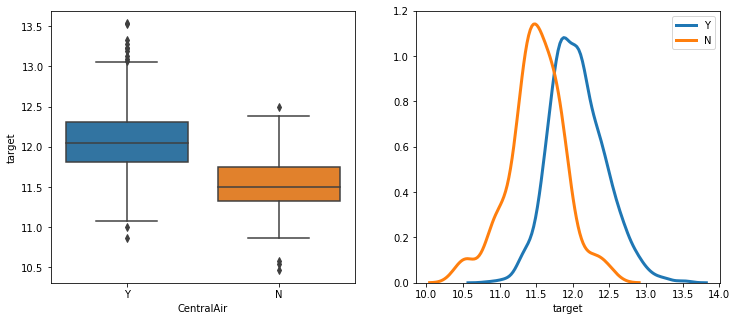

In [25]:
exp.segm_target(train_cleaned, 'CentralAir', 'target')

,count,mean,max,min,median,std
GarageFinish,,,,,,
Fin,278,12.318569,13.534474,11.320566,12.286128,0.370954
NoGrg,65,11.468998,12.208575,10.460271,11.492733,0.351975
RFn,336,12.170259,13.275829,11.133143,12.154785,0.294461
Unf,487,11.833927,13.071072,10.933000,11.813037,0.297419


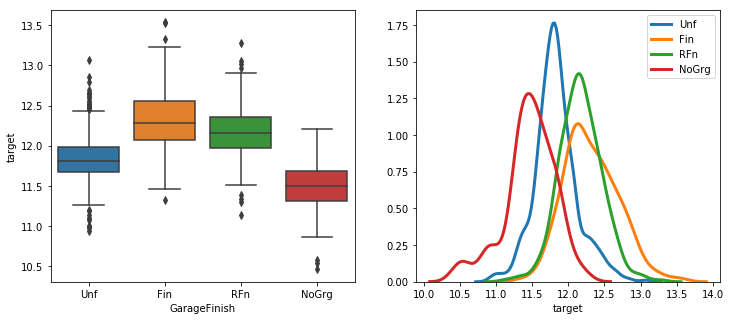

In [26]:
exp.segm_target(train_cleaned, 'GarageFinish', 'target')

Another way of looking at these features is to combine them in a plot together with another numerical feature. We know that `GrLivArea` is going to be important and our function told us that `HouseStyle` has interesting categories in it. We can combine them like this

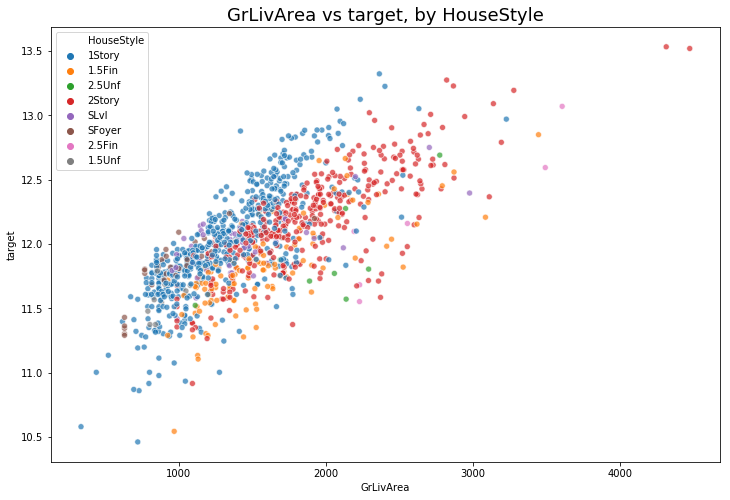

In [27]:
exp.plot_bivariate(train_cleaned, 'GrLivArea', 'target', hue='HouseStyle', alpha=0.7)

Or use this plot to just investigate further the features we have analyzed before

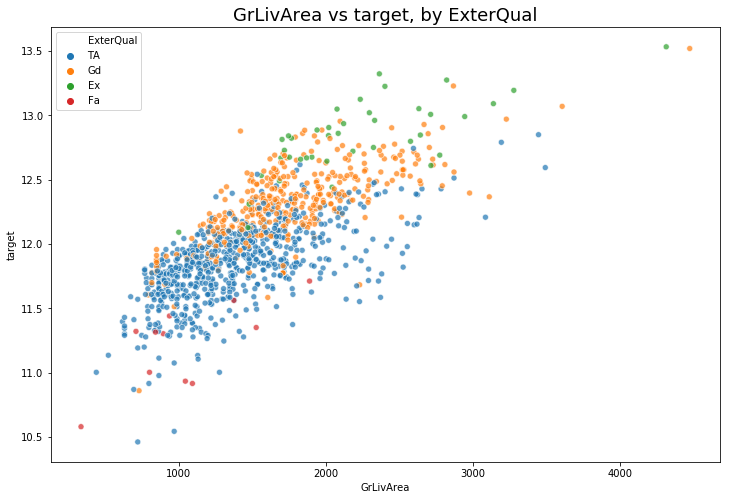

In [28]:
exp.plot_bivariate(train_cleaned, 'GrLivArea', 'target', hue='ExterQual', alpha=0.7)

As mentioned before, it is easy to go too deep in the rabbit hole in this phase. I have been writing this section for an hour already and I feel confident enough about the data to run the first models.

# First models, validation, and error analysis.

This section has multiple goals, the main one is to bridge to the next section about feature engineering. We want to implement a system of evaluating, selecting, and tuning our models that is robust enough to the data processing phase. If we do this part correctly, we will be able to quickly iterate between the processing and modeling phase, being confident that we can correctly assess the validity of our actions. 

As explained already in this notebook https://www.kaggle.com/lucabasa/understand-and-use-a-pipeline, we need different transformations for numeric and categorical features. We will use the insights gained in the previous section to make a few new custom transformers.

In [29]:
class tr_numeric(BaseEstimator, TransformerMixin):
    def __init__(self, SF_room=True, bedroom=True, bath=True, lot=True, service=True):
        self.columns = []  # useful to well behave with FeatureUnion
        

    def fit(self, X, y=None):
        return self
    

    def remove_skew(self, X, column):
        X[column] = np.log1p(X[column])
        return X

    def transform(self, X, y=None):
        for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
            X = self.remove_skew(X, col)

        self.columns = X.columns
        return X
    

    def get_features_name(self):
        return self.columns
    
    
class make_ordinal(BaseEstimator, TransformerMixin):
    '''
    Transforms ordinal features in order to have them as numeric (preserving the order)
    If unsure about converting or not a feature (maybe making dummies is better), make use of
    extra_cols and unsure_conversion
    '''
    def __init__(self, cols, extra_cols=None, include_extra=True):
        self.cols = cols
        self.extra_cols = extra_cols
        self.mapping = {'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        self.include_extra = include_extra
    

    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if self.extra_cols:
            if self.include_extra:
                self.cols += self.extra_cols
            else:
                for col in self.extra_cols:
                    del X[col]
        
        for col in self.cols:
            X.loc[:, col] = X[col].map(self.mapping).fillna(0)
        return X


class recode_cat(BaseEstimator, TransformerMixin):        
    '''
    Recodes some categorical variables according to the insights gained from the
    data exploration phase.
    '''
    def fit(self, X, y=None):
        return self
    
    
    def tr_GrgType(self, data):
        data['GarageType'] = data['GarageType'].map({'Basment': 'Attchd',
                                                  'CarPort': 'Detchd', 
                                                  '2Types': 'Attchd' }).fillna(data['GarageType'])
        return data
    
    
    def tr_LotShape(self, data):
        fil = (data.LotShape != 'Reg')
        data['LotShape'] = 1
        data.loc[fil, 'LotShape'] = 0
        return data
    
    
    def tr_LandCont(self, data):
        fil = (data.LandContour == 'HLS') | (data.LandContour == 'Low')
        data['LandContour'] = 0
        data.loc[fil, 'LandContour'] = 1
        return data
    
    
    def tr_MSZoning(self, data):
        data['MSZoning'] = data['MSZoning'].map({'RH': 'RM', # medium and high density
                                                 'C (all)': 'RM', # commercial and medium density
                                                 'FV': 'RM'}).fillna(data['MSZoning'])
        return data
    
    
    def tr_Alley(self, data):
        fil = (data.Alley != 'NoAlley')
        data['Alley'] = 0
        data.loc[fil, 'Alley'] = 1
        return data
    
    
    def tr_LotConfig(self, data):
        data['LotConfig'] = data['LotConfig'].map({'FR3': 'Corner', # corners have 2 or 3 free sides
                                                   'FR2': 'Corner'}).fillna(data['LotConfig'])
        return data
    
    
    def tr_BldgType(self, data):
        data['BldgType'] = data['BldgType'].map({'Twnhs' : 'TwnhsE',
                                                 '2fmCon': 'Duplex'}).fillna(data['BldgType'])
        return data
    
    
    def tr_MasVnrType(self, data):
        data['MasVnrType'] = data['MasVnrType'].map({'BrkCmn': 'BrkFace'}).fillna(data['MasVnrType'])
        return data


    def tr_HouseStyle(self, data):
        data['HouseStyle'] = data['HouseStyle'].map({'1.5Fin': '1.5Unf',
                                                     '2.5Fin': '2Story',
                                                     '2.5Unf': '2Story',
                                                     'SLvl': 'SFoyer'}).fillna(data['HouseStyle'])
        return data
    
    
    def transform(self, X, y=None):
        X = self.tr_GrgType(X)
        X = self.tr_LotShape(X)
        X = self.tr_LotConfig(X)
        X = self.tr_MSZoning(X)
        X = self.tr_Alley(X)
        X = self.tr_LandCont(X)
        X = self.tr_BldgType(X)
        X = self.tr_MasVnrType(X)
        X = self.tr_HouseStyle(X)
        return X
    

class drop_columns(BaseEstimator, TransformerMixin):
    '''
    Drops columns that are not useful for the model
    '''
    def __init__(self):
        self.columns = []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        to_drop = [col for col in X.columns if 'NoGrg' in col]  # dropping dummies that are redundant
        to_drop += [col for col in X.columns if 'NoBsmt' in col]
        # other not useful columns
        to_drop += [col for col in X.columns if 'MSSubClass' in col]
        to_drop += [col for col in X.columns if 'Neighborhood' in col]  # maybe useful in the future
        to_drop += [col for col in X.columns if 'Condition1' in col]
        to_drop += [col for col in X.columns if 'Condition2' in col]
        to_drop += [col for col in X.columns if 'ExterCond' in col]  # maybe make it ordinal
        to_drop += [col for col in X.columns if 'Exterior1st' in col]
        to_drop += [col for col in X.columns if 'Exterior2nd' in col]
        to_drop += [col for col in X.columns if 'Functional' in col]
        to_drop += [col for col in X.columns if 'Heating_' in col]  # we don't want to drop the dummies of HeatingQC too
        to_drop += [col for col in X.columns if 'PoolQC' in col]
        to_drop += [col for col in X.columns if 'RoofMatl' in col]
        to_drop += [col for col in X.columns if 'RoofStyle' in col]
        to_drop += [col for col in X.columns if 'SaleCondition' in col]
        to_drop += [col for col in X.columns if 'SaleType' in col]
        to_drop += [col for col in X.columns if 'Utilities' in col]
        to_drop += [col for col in X.columns if 'BsmtCond' in col]  # maybe ordinal
        to_drop += [col for col in X.columns if 'Electrical' in col]
        to_drop += [col for col in X.columns if 'Foundation' in col]
        to_drop += [col for col in X.columns if 'LandSlope' in col]
        to_drop += [col for col in X.columns if 'Street' in col]
        to_drop += [col for col in X.columns if 'Fence' in col]
        to_drop += [col for col in X.columns if 'PavedDrive' in col]

        for col in to_drop:
            try:
                del X[col]
            except KeyError:
                pass
            
        self.columns = X.columns
        return X
    
    def get_feature_names(self):
        return list(self.columns)

In [30]:
numeric_pipe = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imputer', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric())])


cat_pipe = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imputer', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual','GarageQual',
                                           'GarageCond', 'ExterQual', 'HeatingQC'])), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify())])


processing_pipe = dfp.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('gen_cl', general_cleaner()), 
                      ('processing', processing_pipe), 
                      ('scaler', dfp.df_scaler()), 
                      ('dropper', drop_columns())])

tmp = train_set.copy()

full_pipe.fit_transform(tmp).head()

,Alley,LotShape,LandContour,ExterQual,BsmtQual,HeatingQC,KitchenQual,GarageQual,GarageCond,MSZoning_RL,MSZoning_RM,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,BldgType_1Fam,BldgType_Duplex,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,CentralAir_N,CentralAir_Y,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFire,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,target,MisBsm,MisGarage
1231,-0.260318,0.739202,-0.24691,-0.691394,-3.956431,-1.195302,-0.766243,0.256754,0.262237,0.523753,-0.523753,1.954017,-0.265908,-1.629470,-2.245318,4.018340,-0.346521,-0.358819,1.015558,-0.692600,-0.27323,-0.67235,0.808641,-0.30292,-0.411714,-0.312935,-0.271413,-1.424279,-0.408861,-0.335552,-0.622973,-0.230862,-0.322749,-0.660273,-0.117954,-0.15102,-0.093008,-0.186025,-0.198030,-2.445820,-0.271413,0.271413,-0.132106,-0.148022,-0.593859,1.063780,-0.114158,-0.529067,-1.236642,-0.264054,1.625961,-0.55952,-0.636254,1.180784,0.378144,0.178389,-1.532470,-0.520843,-0.298452,-1.099477,-0.571568,-0.994151,-0.289380,-1.297802,-2.507078,0.323866,-0.807309,-0.120044,-0.495641,-0.790416,-0.235080,0.795626,-0.775213,-1.098144,4.116721,-0.336957,-0.959872,-0.543172,0.317934,-0.039470,-0.737686,-0.699962,-0.361219,-0.114858,-0.273783,-0.064936,-0.088546,-1.198176,-0.613727,-1.236720,5.952940,-0.242976
1456,-0.260318,0.739202,-0.24691,-0.691394,-0.547664,-0.153656,0.737864,0.256754,0.262237,0.523753,-0.523753,-0.511766,-0.265908,0.613696,0.445371,-0.248859,-0.346521,-0.358819,1.015558,-0.692600,-0.27323,-0.67235,0.808641,-0.30292,-0.411714,-0.312935,3.684427,-1.424279,-0.408861,-0.335552,1.605206,-0.230862,-0.322749,-0.660273,-0.117954,-0.15102,-0.093008,-0.186025,5.049752,-2.445820,-0.271413,0.271413,-0.132106,-0.148022,-0.593859,1.063780,-0.114158,-0.529067,0.808641,-0.264054,-0.615021,-0.55952,-0.636254,1.180784,0.319926,0.153680,-0.805513,0.393770,-0.692632,0.546086,-0.571568,-0.881439,5.992652,-1.297802,0.057797,-0.080602,-0.807309,-0.120044,-0.880038,1.158052,-0.235080,-1.045048,-0.775213,-1.098144,-0.219410,-0.953743,-0.959872,-0.997286,-1.015558,-1.084470,2.128905,-0.699962,1.448993,-0.114858,-0.273783,-0.064936,-0.088546,-0.828482,1.648460,-0.403476,-0.167984,-0.242976
242,-0.260318,0.739202,-0.24691,-0.691394,-0.547664,-0.153656,-0.766243,-1.122854,0.262237,-1.909298,1.909298,1.954017,-0.265908,-1.629470,0.445371,-0.248859,-0.346521,2.786919,-0.984680,-0.692600,-0.27323,-0.67235,0.808641,-0.30292,-0.411714,-0.312935,-0.271413,0.702109,-0.408861,-0.335552,-0.622973,-0.230862,-0.322749,1.514525,-0.117954,-0.15102,-0.093008,-0.186025,-0.198030,0.408861,3.684427,-3.684427,-0.132106,-0.148022,-0.593859,1.063780,-0.114158,-0.529067,0.808641,-0.264054,-0.615021,-0.55952,-0.636254,1.180784,0.174380,-1.130681,-0.805513,-1.435457,-2.335049,-1.680264,-0.571568,-0.994151,-0.289380,-0.077121,-1.222261,-0.694344,0.447417,-0.120044,-0.003745,-0.790416,-0.235080,-1.045048,-0.775213,0.158417,-0.219410,-0.336957,-0.959872,-1.375715,-1.015558,-0.557263,-0.737686,-0.699962,0.883302,-0.114858,-0.273783,-0.064936,-0.088546,-0.828482,-1.367789,-1.869865,-0.167984,-0.242976
93,-0.260318,0.739202,-0.24691,-0.691394,-0.547664,0.887990,-0.766243,0

As you can see, we fill the missing values either with the median or with the mode, we remove the skew from some numerical features, we make some categorical feature ordinal, and we recode some categories accordingly to what we have already seen in the data exploration phase. By also using those insights, we drop some columns to make our model simpler. A few of these columns might be useful later on but for now we can safely drop them.

At the end of this pipeline, we will put a model. We know we need a regressor, but we still don't know what model is going to be good enough for us. We thus need to implement some methods to evaluate the models. At that point, we can simply try some models and focus on the most promising one.

There is no point now to play around with hyperparameters as we still have to try to improve the quality of our data before, which will improve our model far more than a fine tuned parameter

In [31]:
def cv_score(df_train, y_train, kfolds, pipeline):
    oof = np.zeros(len(df_train))
    train = df_train.copy()
    
    
    for train_index, test_index in kfolds.split(train.values):
            
        trn_data = train.iloc[train_index][:]
        val_data = train.iloc[test_index][:]
        
        trn_target = y_train.iloc[train_index].values.ravel()
        val_target = y_train.iloc[test_index].values.ravel()
        
        pipeline.fit(trn_data, trn_target)

        oof[test_index] = pipeline.predict(val_data).ravel()
            
    return oof


def grid_search(data, target, estimator, param_grid, scoring, cv):
    
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, 
                        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    
    pd.options.mode.chained_assignment = None
    tmp = data.copy()
    grid = grid.fit(tmp, target)
    pd.options.mode.chained_assignment = 'warn'
    
    result = pd.DataFrame(grid.cv_results_).sort_values(by='mean_test_score', 
                                                        ascending=False).reset_index()
    
    del result['params']
    times = [col for col in result.columns if col.endswith('_time')]
    params = [col for col in result.columns if col.startswith('param_')]
    splits = result[[col for col in result.columns if col.startswith('split')]].head()
    splits.columns = [col.split('_test')[0] for col in splits.columns]
    
    splits.T.plot(alpha=0.5, figsize=(12,8))
    plt.savefig('../plots/gridsearch.png')
    plt.close()
    
    result = result[params + ['mean_test_score', 'std_test_score'] + times]
    
    return result, grid.best_params_, grid.best_estimator_


def get_coef(pipe):
    imp = pipe.steps[-1][1].coef_.tolist()
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result['abs_res'] = abs(result['score'])
    result = result.sort_values(by=['abs_res'],ascending=False)
    del result['abs_res']
    return result


def get_feature_importance(pipe):
    imp = pipe.steps[-1][1].feature_importances_.tolist() #it's a pipeline
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


def _plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax


def plot_predictions(data, true_label, pred_label, feature=None, hue=None, legend=False):
    
    tmp = data.copy()
    tmp['Prediction'] = pred_label
    tmp['True Label'] = true_label
    tmp['Residual'] = tmp['True Label'] - tmp['Prediction']
    
    diag = False
    alpha = 0.7
    label = ''
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    if feature is None:
        feature = 'True Label'
        diag = True
    else:
        legend = 'full'
        sns.scatterplot(x=feature, y='True Label', data=tmp, ax=ax[0], label='True',
                         hue=hue, legend=legend, alpha=alpha)
        label = 'Predicted'
        alpha = 0.4

    sns.scatterplot(x=feature, y='Prediction', data=tmp, ax=ax[0], label=label,
                         hue=hue, legend=legend, alpha=alpha)
    if diag:
        ax[0] = _plot_diagonal(ax[0])
    
    sns.scatterplot(x=feature, y='Residual', data=tmp, ax=ax[1], 
                    hue=hue, legend=legend, alpha=0.7)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    ax[0].set_title(f'{feature} vs Predictions')
    ax[1].set_title(f'{feature} vs Residuals')

In [32]:
models = [('lasso', Lasso(alpha=0.01)), ('ridge', Ridge()), ('sgd', SGDRegressor()), 
          ('forest', RandomForestRegressor(n_estimators=200)), ('xtree', ExtraTreesRegressor(n_estimators=200)), 
          ('svr', SVR()), 
          ('kneig', KNeighborsRegressor()),
          ('xgb', xgb.XGBRegressor(n_estimators=200, objective='reg:squarederror')), 
          ('lgb', lgb.LGBMRegressor(n_estimators=200))]

mod_name = []
rmse_train = []
rmse_test = []
mae_train = []
mae_test = []

folds = KFold(5, shuffle=True, random_state=541)

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target']
del test_set['target']

warnings.filterwarnings("ignore", 
                        message="The dummies in this set do not match the ones in the train set, we corrected the issue.")

for model in models:
    
    train = train_set.copy()
    test = test_set.copy()
    print(model[0])
    mod_name.append(model[0])
    
    pipe = [('gen_cl', general_cleaner()),
            ('processing', processing_pipe),
            ('scl', dfp.df_scaler()),
            ('dropper', drop_columns())] + [model]
    
    model_pipe = Pipeline(pipe)
            
    inf_preds = cv_score(train, y, folds, model_pipe)
    
    model_pipe.fit(train, y)  # refit on full train set
    
    preds = model_pipe.predict(test)
    
    rmse_train.append(mean_squared_error(y, inf_preds))
    rmse_test.append(mean_squared_error(y_test, preds))
    mae_train.append(mean_absolute_error(np.expm1(y), np.expm1(inf_preds)))
    mae_test.append(mean_absolute_error(np.expm1(y_test), np.expm1(preds)))
    
    print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, inf_preds)), 4)}')
    print(f'\tTrain set MAE: {round(mean_absolute_error(np.expm1(y), np.expm1(inf_preds)), 2)}')
    print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, preds)), 4)}')
    print(f'\tTrain set MAE: {round(mean_absolute_error(np.expm1(y_test), np.expm1(preds)), 2)}')
    
    print('_'*40)
    print('\n')
    
results = pd.DataFrame({'model_name': mod_name, 
                        'rmse_train': rmse_train, 'rmse_test': rmse_test,
                        'mae_train': mae_train, 'mae_test': mae_test})

results

lasso
	Train set RMSE: 0.1357
	Train set MAE: 18201.05
	Test set RMSE: 0.1414
	Train set MAE: 17177.23
________________________________________


ridge
	Train set RMSE: 0.1736
	Train set MAE: 22744.17
	Test set RMSE: 0.1441
	Train set MAE: 17141.26
________________________________________


sgd
	Train set RMSE: 0.2645
	Train set MAE: 31928.46
	Test set RMSE: 0.145
	Train set MAE: 17198.17
________________________________________


forest
	Train set RMSE: 0.1517
	Train set MAE: 19686.94
	Test set RMSE: 0.1617
	Train set MAE: 18965.48
________________________________________


xtree
	Train set RMSE: 0.1772
	Train set MAE: 22785.49
	Test set RMSE: 0.1771
	Train set MAE: 21245.34
________________________________________


svr
	Train set RMSE: 0.3538
	Train set MAE: 48779.12
	Test set RMSE: 0.3283
	Train set MAE: 42957.59
________________________________________


kneig
	Train set RMSE: 0.3562
	Train set MAE: 45597.58
	Test set RMSE: 0.3127
	Train set MAE: 42496.49
_________________________

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


	Train set RMSE: 0.1463
	Train set MAE: 19263.11
	Test set RMSE: 0.1512
	Train set MAE: 17771.68
________________________________________


lgb
	Train set RMSE: 0.1488
	Train set MAE: 19300.52
	Test set RMSE: 0.1544
	Train set MAE: 17652.14
________________________________________




,model_name,rmse_train,rmse_test,mae_train,mae_test
0,lasso,0.018417,0.019999,18201.047730,17177.225144
1,ridge,0.030136,0.020751,22744.165714,17141.262483
2,sgd,0.069950,0.021038,31928.463812,17198.165095
3,forest,0.023021,0.026156,19686.944268,18965.482857
4,xtree,0.031389,0.031368,22785.490039,21245.337048
5,svr,0.125159,0.107793,48779.116977,42957.594561
6,kneig,0.126895,0.097801,45597.584879,42496.494932
7,xgb,0.021400,0.022856,19263.113870,17771.682631
8,lgb,0.022145,0.023838,19300.519951,17652.136542


We will continue with the top5: Lasso, RandomForest, XGBoost, LGBoost, Ridge. We will have these results as baseline, being them the one we obtained by simply looking at the data.

We can investigate each of these models by looking at their predictions and at how those predictions are made. For example

In [33]:
lasso_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('processing', processing_pipe),
                       ('scl', dfp.df_scaler()), 
                       ('dropper', drop_columns()), 
                       ('lasso', Lasso(alpha=0.01))])

lasso_oof = cv_score(train_set, y, folds, lasso_pipe)

get_coef(lasso_pipe)  # todo: these are actually the coefficients for the last fold. It will change.

,feat,score
68,GrLivArea,0.114834
56,OverallQual,0.095245
58,YearBuilt,0.042341
55,LotArea,0.037297
61,BsmtFinSF1,0.036601
...,...,...
36,BsmtFinType2_GLQ,-0.000000
35,BsmtFinType2_BLQ,-0.000000
34,BsmtFinType2_ALQ,0.000000
33,BsmtFinType1_Unf,0.000000


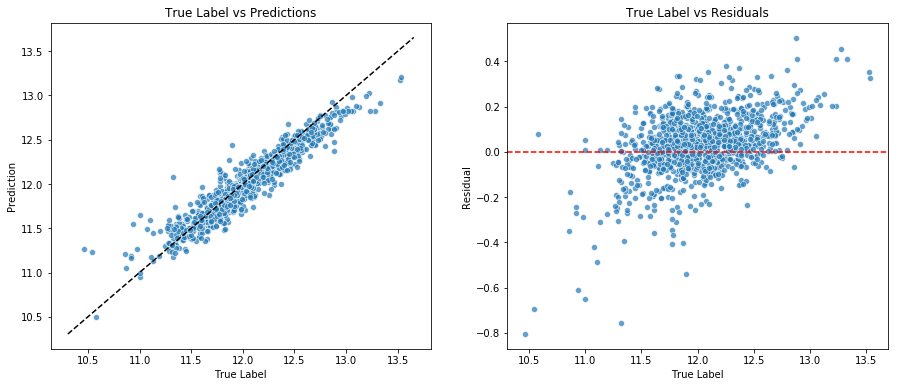

In [34]:
plot_predictions(train_set, y, lasso_oof)

This residual plot is fairly problematic and we will address it later on. 

We also notice that quite a few features do not matter for our predictions

In [35]:
coef_lasso = get_coef(lasso_pipe)

coef_lasso[coef_lasso.score==0].sample(10)

,feat,score
69,BsmtFullBath,0.0
33,BsmtFinType1_Unf,0.0
83,3SsnPorch,-0.0
48,GarageType_Attchd,-0.0
54,LotFrontage,-0.0
43,FireplaceQu_Fa,-0.0
29,BsmtFinType1_BLQ,-0.0
37,BsmtFinType2_LwQ,-0.0
36,BsmtFinType2_GLQ,-0.0
0,Alley,-0.0


# Feature engineering and Feature selection

We have already implemented a few transformations for our base models. For example, we have already removed the skew from some numerical features and we can see that the result is promising

           GrLivArea  1stFlrSF   LotArea    target
GrLivArea   1.000000  0.532700  0.375878  0.741597
1stFlrSF    0.532700  1.000000  0.455827  0.611572
LotArea     0.375878  0.455827  1.000000  0.407437
target      0.741597  0.611572  0.407437  1.000000


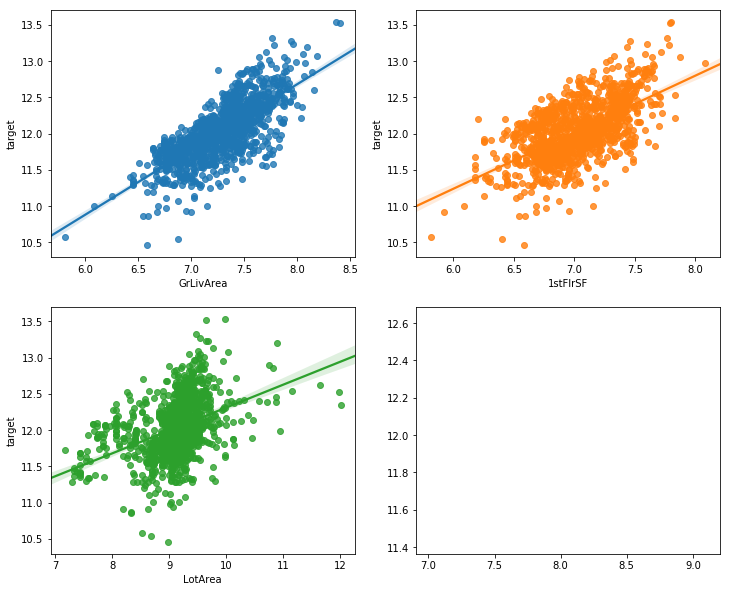

In [36]:
for col in ['GrLivArea', '1stFlrSF', 'LotArea']:
    train_cleaned[col] = np.log1p(train_cleaned[col])

exp.corr_target(train_cleaned, 'target', ['GrLivArea', '1stFlrSF', 'LotArea'])

Moreover, we have already transformed some categorical features into ordinal ones

             BsmtQual  KitchenQual  GarageQual  GarageCond  ExterQual  \
BsmtQual     1.000000     0.511100    0.171536    0.188111   0.554887   
KitchenQual  0.511100     1.000000    0.232329    0.224139   0.714989   
GarageQual   0.171536     0.232329    1.000000    0.955815   0.214681   
GarageCond   0.188111     0.224139    0.955815    1.000000   0.210297   
ExterQual    0.554887     0.714989    0.214681    0.210297   1.000000   
HeatingQC    0.403084     0.499017    0.176256    0.181200   0.520420   
target       0.607152     0.690173    0.372389    0.365264   0.688002   

             HeatingQC    target  
BsmtQual      0.403084  0.607152  
KitchenQual   0.499017  0.690173  
GarageQual    0.176256  0.372389  
GarageCond    0.181200  0.365264  
ExterQual     0.520420  0.688002  
HeatingQC     1.000000  0.483002  
target        0.483002  1.000000  


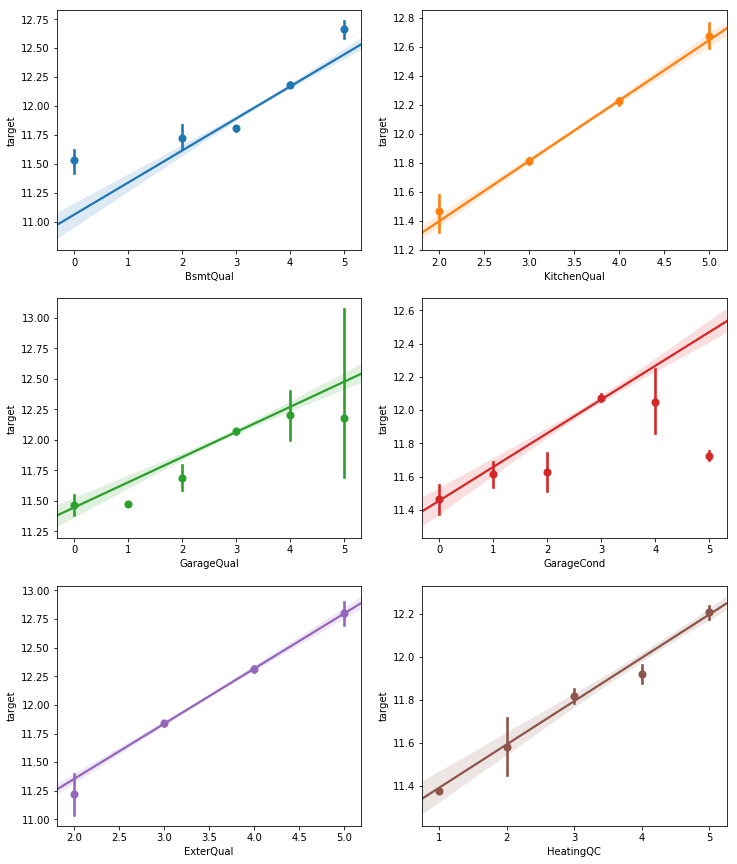

In [37]:
train_cleaned = make_ordinal(['BsmtQual', 'KitchenQual',
                              'GarageQual','GarageCond', 
                              'ExterQual', 'HeatingQC']).fit_transform(train_cleaned)

exp.corr_target(train_cleaned, 'target', ['BsmtQual', 'KitchenQual',
                                          'GarageQual','GarageCond',
                                          'ExterQual', 'HeatingQC'], x_estimator=np.mean)

We indeed observe a linear relation between the target and some of these features. For others it will be probably be better to use a different encoding.

At last, at least regarding what we have already implemented, we recoded a few categories following common sense. The goal here is to not train on too rare categories as this can lead to poor generalizability of the model. We report here only one of those transformations as an example

,count,mean,max,min,median,std
GarageType,,,,,,
Attchd,705,12.154445,13.534474,10.933000,12.119975,0.340577
BuiltIn,76,12.381833,13.275829,11.418626,12.334850,0.393289
Detchd,320,11.771839,13.071072,10.976799,11.763692,0.272710
NoGrg,65,11.468998,12.208575,10.460271,11.492733,0.351975


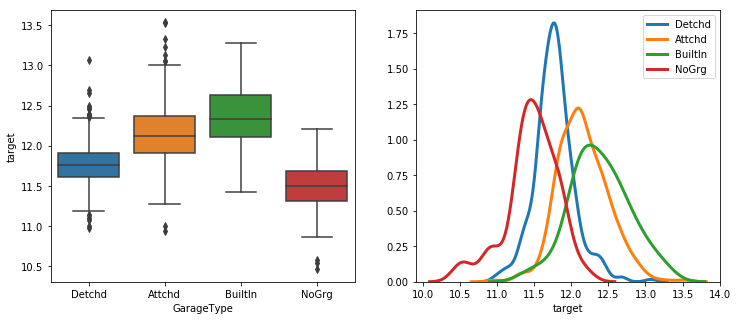

In [38]:
train_cleaned = recode_cat().fit_transform(train_cleaned)

exp.segm_target(train_cleaned, 'GarageType', 'target')

As we can see, the differences among different categories are more clear. This will definitely help the models.


## New features and what suggested them

We will now use some insights gained during the data exploration phase to make better features.

We noticed a good correlation between TotRmsAbvGrd, GrLivArea, and BedroomAbvGr, which is nothing shocking. Let's see what an interaction between the two looks like.

              GrLivArea  TotRmsAbvGrd  BedroomAbvGr  sf_per_room  \
GrLivArea      1.000000      0.819665      0.543195    -0.726105   
TotRmsAbvGrd   0.819665      1.000000      0.677524    -0.927202   
BedroomAbvGr   0.543195      0.677524      1.000000    -0.672979   
sf_per_room   -0.726105     -0.927202     -0.672979     1.000000   
bedroom_prop  -0.217718     -0.229407      0.530716     0.164960   
target         0.741597      0.543633      0.210188    -0.465772   

              bedroom_prop    target  
GrLivArea        -0.217718  0.741597  
TotRmsAbvGrd     -0.229407  0.543633  
BedroomAbvGr      0.530716  0.210188  
sf_per_room       0.164960 -0.465772  
bedroom_prop      1.000000 -0.320894  
target           -0.320894  1.000000  


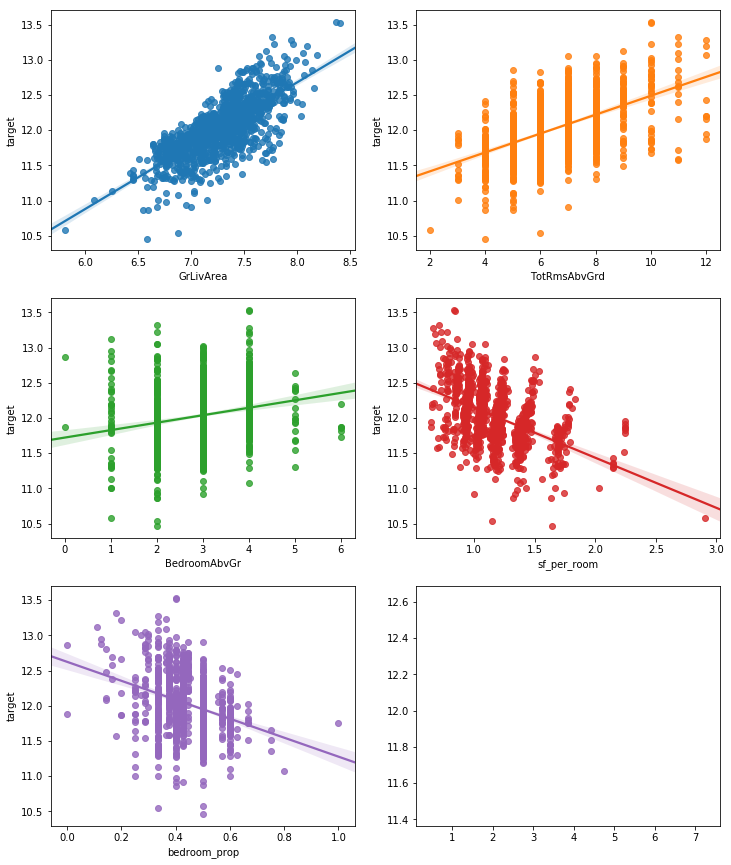

In [39]:
def SF_per_room(data):
    data['sf_per_room'] = data['GrLivArea'] / data['TotRmsAbvGrd']
    return data

def bedroom_prop(data):
    data['bedroom_prop'] = data['BedroomAbvGr'] / data['TotRmsAbvGrd']
    return data

train_cleaned = SF_per_room(train_cleaned)
train_cleaned = bedroom_prop(train_cleaned)

exp.corr_target(data=train_cleaned, 
                cols=['GrLivArea', 'TotRmsAbvGrd', 'BedroomAbvGr', 'sf_per_room', 'bedroom_prop'], 
                target='target')

It looks we found something: the bigger the house, the more it costs, but the bigger the rooms (on average), the less the house is expensive.

Next, we have a lot of bath features that individually are not saying too much. Let's try to make something out of them.

              BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  total_bath  \
BsmtFullBath      1.000000     -0.149458 -0.053973 -0.031788    0.582381   
BsmtHalfBath     -0.149458      1.000000 -0.019015 -0.011742    0.031650   
FullBath         -0.053973     -0.019015  1.000000  0.162049    0.703567   
HalfBath         -0.031788     -0.011742  0.162049  1.000000    0.408878   
total_bath        0.582381      0.031650  0.703567  0.408878    1.000000   
target            0.246349      0.006646  0.589437  0.343117    0.677673   

                target  
BsmtFullBath  0.246349  
BsmtHalfBath  0.006646  
FullBath      0.589437  
HalfBath      0.343117  
total_bath    0.677673  
target        1.000000  


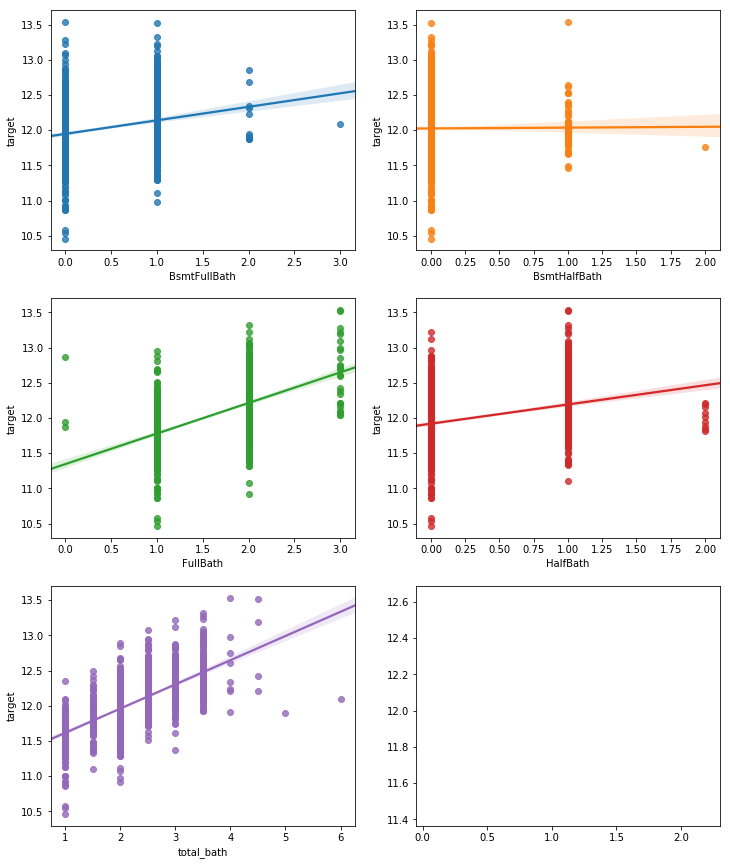

In [40]:
def total_bath(data):
    data['total_bath'] = data[[col for col in data.columns if 'FullBath' in col]].sum(axis=1) \
                        + 0.5 * data[[col for col in data.columns if 'HalfBath' in col]].sum(axis=1)
    return data

train_cleaned = total_bath(train_cleaned)
exp.corr_target(data=train_cleaned, 
                cols=[col for col in train_cleaned if 'Bath' in col] + ['total_bath'], 
                target='target')

This is indeed a clearer signal and we should consider using this feature and dropping the other bath features.

We also have quite some features regarding external area (porch, Lot, Pool), but with the exception of LotArea, they are not very relevant. We thus can try to see if some interaction with the internal area is relevant.

            LotArea  GrLivArea  lot_prop    target
LotArea    1.000000   0.375878  0.683041  0.407437
GrLivArea  0.375878   1.000000 -0.418644  0.741597
lot_prop   0.683041  -0.418644  1.000000 -0.185828
target     0.407437   0.741597 -0.185828  1.000000


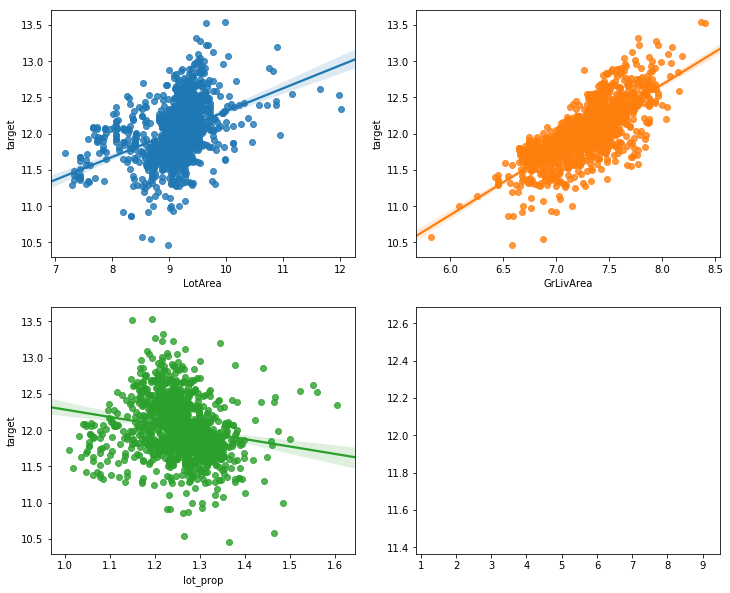

In [41]:
def lot_prop(data):
    data['lot_prop'] = data['LotArea'] / data['GrLivArea']
    return data

train_cleaned = lot_prop(train_cleaned)

exp.corr_target(data=train_cleaned,
                cols=['LotArea', 'GrLivArea', 'lot_prop'],
                target='target')

Nothing game-changing here but, with the same spirity, we can see what role what we can call service areas (Basement and Garage) are playing.

              TotalBsmtSF  GarageArea  service_area    target
TotalBsmtSF      1.000000    0.474743      0.941255  0.641253
GarageArea       0.474743    1.000000      0.744070  0.673793
service_area     0.941255    0.744070      1.000000  0.745304
target           0.641253    0.673793      0.745304  1.000000


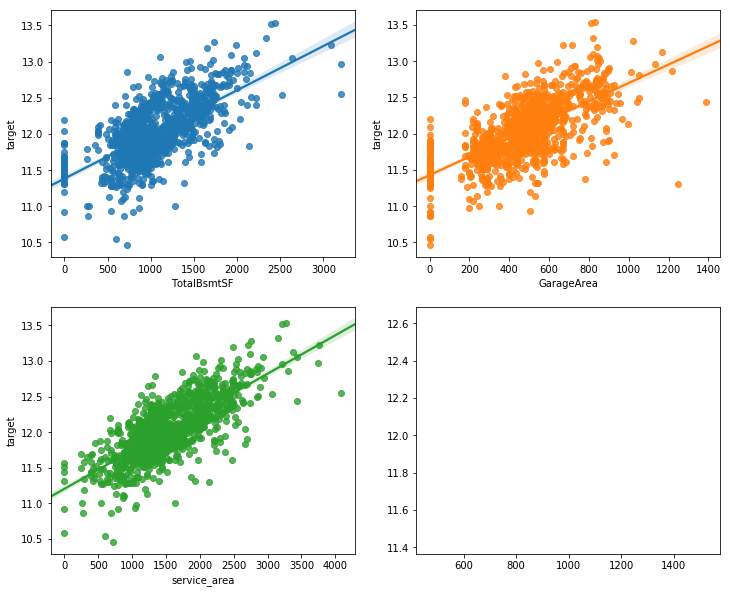

In [42]:
def service_area(data):
    data['service_area'] = data['TotalBsmtSF'] + data['GarageArea']
    return data

train_cleaned = service_area(train_cleaned)

exp.corr_target(data=train_cleaned,
                cols=['TotalBsmtSF', 'GarageArea', 'service_area'],
                target='target')

Since we already have GarageCars to describe the Garage and this new feature is very correlated with the basement SF, we could consider if it is better to use it and drop the original two.

At last, for now, we can use a very powerful but dangerous encoding technique to make a better use of `Neighborhood`. We want to use *target encoding* and, as we will see, it will give us a very predictive feature. However, one must be cautious about using this kind of encoding as it easily lead to severe overfitting.

Two things can prevent the overfitting: the use of pipeline (so we are sure that the encoding happens only on the training set) and some smoothing techniques (so that there is some noise in the feature and the signal is not unrealistically clean). We will implement these features shortly but, for now, we explore the possibilities we have.

                     GrLivArea  Neig_target_mean  Neig_target_std  \
GrLivArea             1.000000          0.472654         0.069002   
Neig_target_mean      0.472654          1.000000        -0.005510   
Neig_target_std       0.069002         -0.005510         1.000000   
Neig_GrLivArea_mean   0.539327          0.876378         0.127942   
Neig_GrLivArea_std   -0.200661         -0.485380         0.467475   
target                0.741597          0.754919        -0.004160   

                     Neig_GrLivArea_mean  Neig_GrLivArea_std    target  
GrLivArea                       0.539327           -0.200661  0.741597  
Neig_target_mean                0.876378           -0.485380  0.754919  
Neig_target_std                 0.127942            0.467475 -0.004160  
Neig_GrLivArea_mean             1.000000           -0.372058  0.661594  
Neig_GrLivArea_std             -0.372058            1.000000 -0.366422  
target                          0.661594           -0.366422  1.000000  


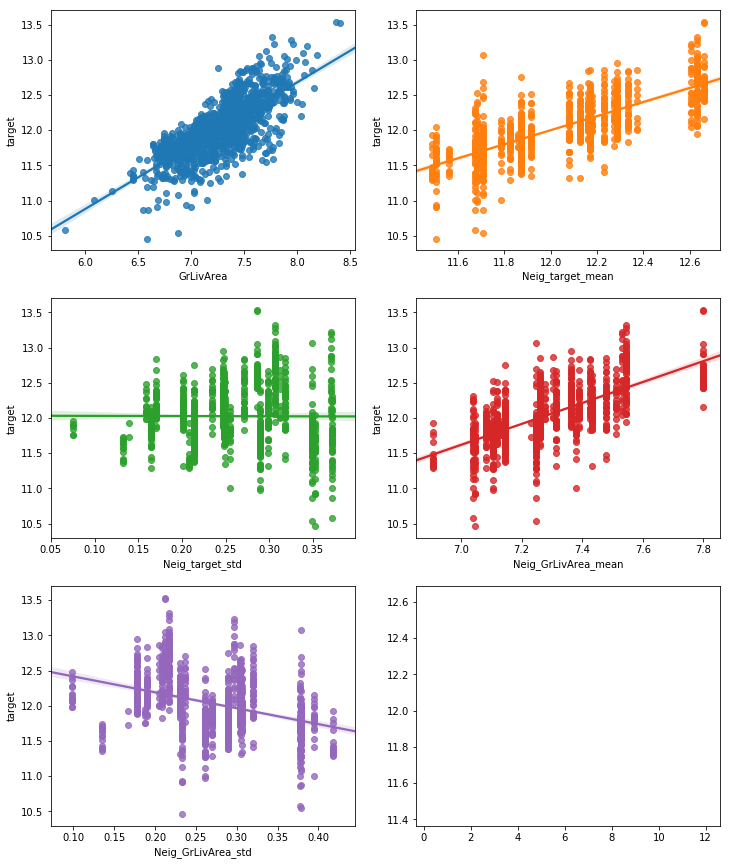

In [43]:
def tr_neighborhood(data, y=None):
    # mean and standard deviation of the price per Neighborhood
    means = data.groupby('Neighborhood')['target'].mean()
    stds = data.groupby('Neighborhood')['target'].std()
    data['Neig_target_mean'] = data['Neighborhood'].map(means)
    data['Neig_target_std'] = data['Neighborhood'].map(stds)
    # mean and standard deviation of the house size per Neighborhood
    means = data.groupby('Neighborhood')['GrLivArea'].mean()
    stds = data.groupby('Neighborhood')['GrLivArea'].std()
    data['Neig_GrLivArea_mean'] = data['Neighborhood'].map(means)
    data['Neig_GrLivArea_std'] = data['Neighborhood'].map(stds)
    
    return data

train_cleaned = tr_neighborhood(train_cleaned)

exp.corr_target(train_cleaned, 'target', ['GrLivArea', 
                                          'Neig_target_mean','Neig_target_std',
                                          'Neig_GrLivArea_mean', 'Neig_GrLivArea_std'])

It looks like the target encoding with the mean is very powerful and not very correlated with the other features. We will use this one.


## Feature selection

We have seen from the previous models already that some features do not look important at all. Not only they slow down the learning, but they can even make our models learn the wrong relationships. We thus now modify the pipeline in order to get rid of these features.

### To be continued. Thank your reading this unfinished notebook, please feel free to ask for clarification or suggest other things I should cover in the next sections (even if most of them are already planned)